In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn
from pandas_datareader import data

tickers = ['SPY','AAPL','ADBE','LUV','MSFT', 'SKYW','QCOM', 'HPQ','JNPR','AMD','IBM']


In [3]:
def load_financial_data(symbols, start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
    except FileNotFoundError:
        df = data.DataReader(symbols, 'yahoo', start_date, end_date)
        df.to_pickle(output_file)
    return df

def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:
                pairs.append((keys[i], keys[j]))

    return pvalue_matrix, pairs

In [4]:
data = load_financial_data(tickers, '2001-01-01', '2018-01-01', 'multi_data_large.pkl')

In [5]:
pvalues, pairs = find_cointegrated_pairs(data['Adj Close'])
# print(pairs)

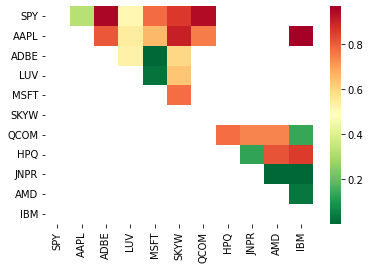

In [6]:
seaborn.heatmap(pvalues, xticklabels=tickers,
                yticklabels=tickers, cmap='RdYlGn_r',
                mask=(pvalues >= 0.98))
plt.show()
# print(pairs)
# print(data.head(3))

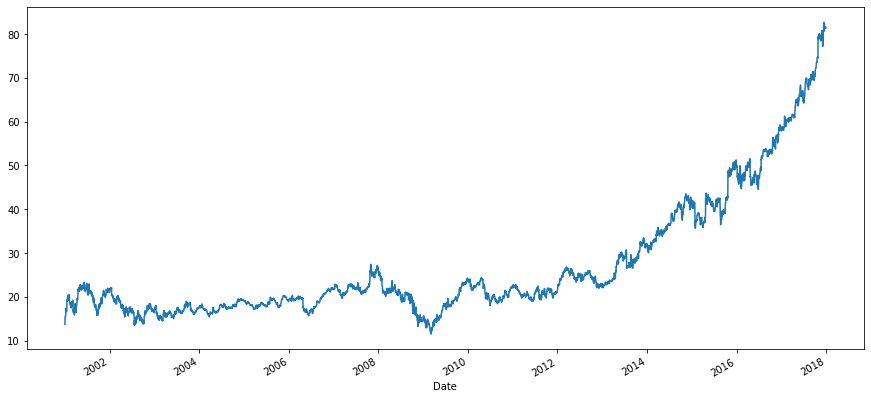

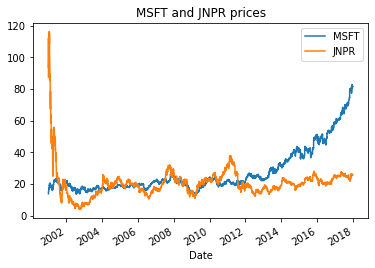

In [7]:
Symbol1_prices = data['Adj Close']['MSFT']
Symbol1_prices.plot(figsize=(15, 7))
plt.show()
Symbol2_prices = data['Adj Close']['JNPR']
Symbol2_prices.name = 'JNPR'
plt.title("MSFT and JNPR prices")
Symbol1_prices.plot()
Symbol2_prices.plot()
plt.legend()
plt.show()


In [8]:
pair_correlation_trading_strategy = pd.DataFrame(index=Symbol1_prices.index)
pair_correlation_trading_strategy['symbol1_price'] = Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell'] = np.zeros(
    len(Symbol1_prices))


1.0


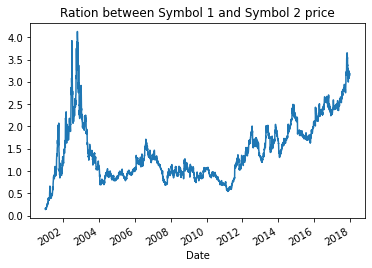

In [11]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

score, pvalue, _ = coint(Symbol1_prices, Symbol2_prices)
print(pvalue)
ratios = Symbol1_prices / Symbol2_prices
plt.title("Ration between Symbol 1 and Symbol 2 price")

ratios.plot()
plt.show()


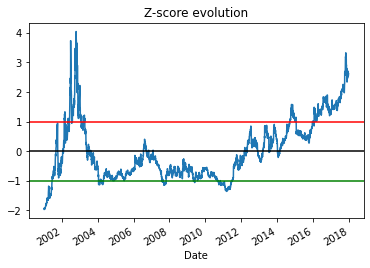

In [12]:
zscore(ratios).plot()
plt.title("Z-score evolution")
plt.axhline(zscore(ratios).mean(), color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()


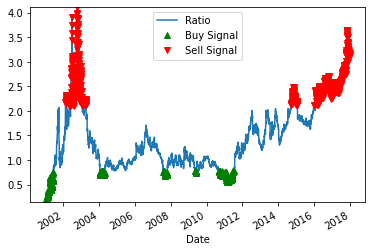

<AxesSubplot:xlabel='Date'>

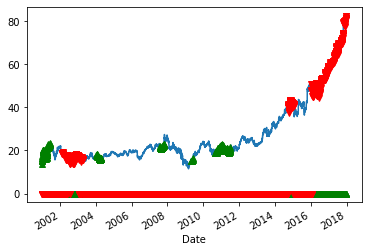

In [13]:
ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios) > -1] = 0
sell[zscore(ratios) < 1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()


symbol1_buy = Symbol1_prices.copy()
symbol1_sell = Symbol1_prices.copy()
symbol2_buy = Symbol2_prices.copy()
symbol2_sell = Symbol2_prices.copy()

Symbol1_prices.plot()
symbol1_buy[zscore(ratios) > -1] = 0
symbol1_sell[zscore(ratios) < 1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")


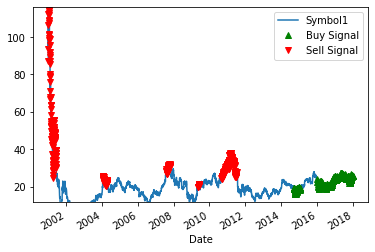

In [16]:
pair_correlation_trading_strategy = pd.DataFrame(index=Symbol1_prices.index)
pair_correlation_trading_strategy['symbol1_price'] = Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell'] = np.zeros(
    len(Symbol1_prices))

position = 0
for i in range(len(Symbol1_prices)):
    s1price = Symbol1_prices[i]
    s2price = Symbol2_prices[i]
    if not position and symbol1_buy[i] != 0:
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 1
    elif not position and symbol1_sell[i] != 0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = -1
    elif position == -1 and (symbol1_sell[i] == 0 or i == len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 0
    elif position == 1 and (symbol1_buy[i] == 0 or i == len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = 0

Symbol2_prices.plot()
symbol2_buy[zscore(ratios) < 1] = 0
symbol2_sell[zscore(ratios) > -1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, Symbol1_prices.min(), Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal", "Symbol2"])
plt.show()


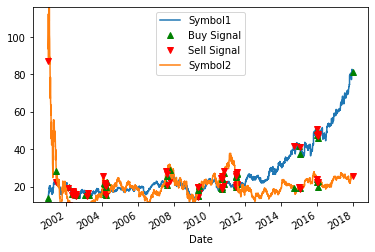

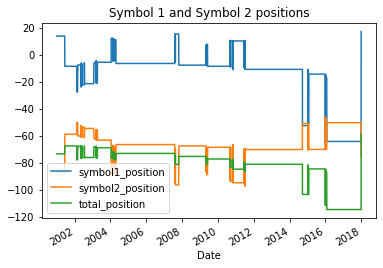

In [17]:
Symbol1_prices.plot()
pair_correlation_trading_strategy['symbol1_buy'].plot(
    color="g", linestyle="None", marker="^")
pair_correlation_trading_strategy['symbol1_sell'].plot(
    color="r", linestyle="None", marker="v")
Symbol2_prices.plot()
pair_correlation_trading_strategy['symbol2_buy'].plot(
    color="g", linestyle="None", marker="^")
pair_correlation_trading_strategy['symbol2_sell'].plot(
    color="r", linestyle="None", marker="v")
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, Symbol1_prices.min(), Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal", "Symbol2"])
plt.show()

pair_correlation_trading_strategy['symbol1_buy'].head()

pair_correlation_trading_strategy['symbol1_position'] =\
    pair_correlation_trading_strategy['symbol1_buy'] - \
    pair_correlation_trading_strategy['symbol1_sell']

pair_correlation_trading_strategy['symbol2_position'] =\
    pair_correlation_trading_strategy['symbol2_buy'] - \
    pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot()

pair_correlation_trading_strategy['total_position'] =\
    pair_correlation_trading_strategy['symbol1_position'] + \
    pair_correlation_trading_strategy['symbol2_position']
pair_correlation_trading_strategy['total_position'].cumsum().plot()
plt.title("Symbol 1 and Symbol 2 positions")
plt.legend()
plt.show()

pair_correlation_trading_strategy['symbol1_price'] = Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell'] = np.zeros(
    len(Symbol1_prices))
pair_correlation_trading_strategy['delta'] = np.zeros(len(Symbol1_prices))


In [ ]:
position = 0
s1_shares = 1000000
for i in range(len(Symbol1_prices)):
    s1positions = Symbol1_prices[i] * s1_shares
    s2positions = Symbol2_prices[i] * int(s1positions/Symbol2_prices[i])
    print(Symbol1_prices[i], Symbol2_prices[i])
    delta_position = s1positions-s2positions
    if not position and symbol1_buy[i] != 0:
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = 1
    elif not position and symbol1_sell[i] != 0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = -1
    elif position == -1 and (symbol1_sell[i] == 0 or i == len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        position = 0
    elif position == 1 and (symbol1_buy[i] == 0 or i == len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        position = 0


pair_correlation_trading_strategy['symbol1_position'] =\
    pair_correlation_trading_strategy['symbol1_buy'] - \
    pair_correlation_trading_strategy['symbol1_sell']

pair_correlation_trading_strategy['symbol2_position'] =\
    pair_correlation_trading_strategy['symbol2_buy'] - \
    pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot()

pair_correlation_trading_strategy['total_position'] =\
    pair_correlation_trading_strategy['symbol1_position'] + \
    pair_correlation_trading_strategy['symbol2_position']
pair_correlation_trading_strategy['total_position'].cumsum().plot()
plt.title("Symbol 1 and Symbol 2 positions")
plt.legend()
plt.show()


pair_correlation_trading_strategy['delta'].plot()
plt.title("Delta Position")
plt.show()
